## Реализация билатерального фильтра
В этом задании вам предстоит реализовать билатеральный фильтр. Будем реализовывать его маленькими частями.

In [23]:
import numpy as np
from skimage import img_as_float, io, transform
from matplotlib import pyplot as plt

In [24]:
import matplotlib

# Выставите те, что удобны вам
matplotlib.rcParams['figure.figsize'] = (20, 10)

Первым делом проверим что изображение и гид имеют одинаковые размеры. Нас интересует только высота и ширина.

In [3]:
def check_images(image, guide) -> bool:
    h_i, w_i = image.shape[:2]
    h_g, w_g = guide.shape[:2]
    return h_i == h_g and w_i == w_g

In [4]:
assert check_images(image=np.random.randn(10, 10, 3), guide=np.random.randn(10, 10, 3))
assert check_images(image=np.random.randn(10, 10, 3), guide=np.random.randn(10, 10, 1))
assert check_images(image=np.random.randn(10, 10, 1), guide=np.random.randn(10, 10, 1))

assert not check_images(image=np.random.randn(10, 10, 3), guide=np.random.randn(10, 11, 3))
assert not check_images(image=np.random.randn(12, 10, 3), guide=np.random.randn(10, 10, 3))

Мы будем использовать фильтр свертки с динамическими весами. Такие фильтры уменьшают размер изображения. Для сохранения исходного размера изображения нам потребуется функция паддинга.

In [5]:
def pad_image(image,
              pad_size, # Размер отступа
              mode='symmetric' # Передается в np.pad
             ) -> np.array:
    h, w = image.shape[:2]
    if image.ndim == 3:
        return np.pad(image, [(pad_size, pad_size), (pad_size, pad_size), (0, 0)], mode=mode)
    else:
        return np.pad(image, [(pad_size, pad_size), (pad_size, pad_size)], mode=mode)

In [6]:
dummy_input = np.ones([3, 3])
assert pad_image(np.ones([3, 3]), 1).shape == (5, 5)
assert pad_image(np.ones([3, 3, 3]), 1).shape == (5, 5, 3)
assert pad_image(np.ones([3, 3, 1]), 1).shape == (5, 5, 1)

In [7]:
def get_distance_kernel(kernel_size, sigma) -> np.array:
    x, y = np.meshgrid(np.arange(kernel_size) - kernel_size//2, np.arange(kernel_size) - kernel_size//2)
    distance_kernel = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    return distance_kernel

Теперь реализуем функцию, создающую ядро, основанное на разницу в яркости пикселей. Обратите внимание, что изображение может быть как одноканальным, так и многоканальным.

In [8]:
# @numba.jit(nopython=True, parallel=True)
def get_intencity_kernel(pixel_value, # Значения центрального (референсного) пикселя
                         image_slice, # Срез картинки размером с ядро вокруг референсного пикселя
                         sigma
                        ) -> np.array:
    diff_matrix = image_slice - pixel_value
    if image_slice.ndim == 3:
        diff_matrix = np.sqrt((diff_matrix**2).sum(-1))
    return np.exp(-diff_matrix / (2 * sigma**2))

In [9]:
assert np.allclose(get_intencity_kernel(0, np.ones([3, 3]), 1), 0.60653066)
assert np.allclose(get_intencity_kernel(1, np.ones([3, 3]), 1), 1)
assert np.allclose(get_intencity_kernel(1, np.ones([3, 3, 3]), 1), 1)
assert np.allclose(get_intencity_kernel(0, np.ones([3, 3, 3]), 1), 0.42062003)

Наконец создадим основной проход по изображению. Тут нам необходимо:
1. Создать ядро для каждого пикселя
2. Свернуть всех соседей полученным ядром
3. Привести значение пикселей на отрезок [0, 1] (Гаранитируем вход такого формата далее)


In [10]:
def main_loop(padded_image,
              padded_guide,
              distance_kernel,
              sigma_r,
              pad_size,
              kernel_size,
              output # Сюда будет записывать результат
             ) -> np.array:
    
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            padded_i = i + pad_size
            padded_j = j + pad_size
            
            intencity_kernel = get_intencity_kernel(padded_guide[padded_i, padded_j],
                                                    padded_guide[i:i+kernel_size, j:j+kernel_size],
                                                    sigma_r
                                                   )
            pixel_kernel = intencity_kernel * distance_kernel
            pixel_kernel /= pixel_kernel.sum()
            
            if padded_image.ndim == 3:
                pixel_kernel = np.expand_dims(pixel_kernel, -1)
                if padded_image.shape[-1] != 1:
                    pixel_kernel = np.concatenate((pixel_kernel,pixel_kernel, pixel_kernel), -1)
            if padded_image.ndim == 2: 
                output[i, j] = (padded_image[i:i+kernel_size, j:j+kernel_size] * pixel_kernel).sum()
            else:
                output[i, j] = (padded_image[i:i+kernel_size, j:j+kernel_size] * pixel_kernel).sum(0).sum(0)
    return np.clip(output, 0, 1)

Объеденим все вышенаписанное в одну функцию

In [11]:
def bilateralfilter(image,
                    guide,
                    sigma_s, # Сигма для ядра на основе расстояний
                    sigma_r # Сигма для ядра на основе яркостей
                   ) -> np.array:
    # Первым делом надо привести изображения в формат float
    image = img_as_float(image)
    guide = img_as_float(guide)
    
    # Затем проверяем валидность изображений
    if not check_images(image, guide):
        raise Exeption('Guidance not aligned with image')
        
    # Расчитываем размер ядра и паддинга исходя из соображений, что для гауссова ядра нужне размер 6*sigma
    pad_size = int(np.ceil(3 * sigma_s))
    kernel_size = 2 * pad_size + 1
    
    
    padded_image = pad_image(image, pad_size)
    padded_guide = pad_image(guide, pad_size)
    
    # Предподсчитываем ядро на основе расстояний
    
    distance_kernel = get_distance_kernel(kernel_size, sigma_s)
    
    # Запускаем основной расчет
    output = np.zeros_like(image)
    output = main_loop(padded_image, padded_guide, distance_kernel, sigma_r, pad_size, kernel_size, output)
    return output

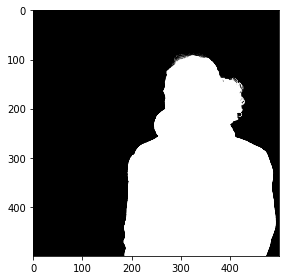

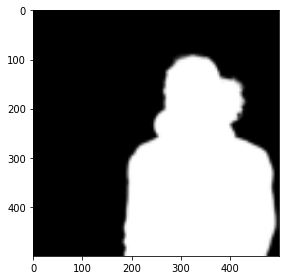

In [12]:
removed = io.imread('./media/mask_portrait.png')
img = io.imread('./media/portrait.jpeg')

img = transform.resize(img, [500, 500])

# Портим сегментационную маску. Для интереса
removed_bad =  transform.resize(removed[..., -1], [100, 100])
removed_bad =  transform.resize(removed_bad, [500, 500])

io.imshow(removed[..., -1])
io.show()
io.imshow(removed_bad)

In [13]:
from tqdm import tqdm_notebook

In [14]:
%%time
res = bilateralfilter(removed_bad,
                      img,
                      20,
                      15/255
                     )

CPU times: user 2min 1s, sys: 1.31 s, total: 2min 2s
Wall time: 2min 3s


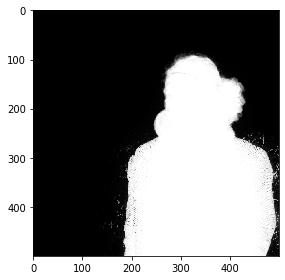

In [15]:
io.imshow(res)

In [16]:
io.imsave('./media/bilateral_result.png', (res*255).astype(np.ubyte))

In [17]:
assert np.allclose((res*255).astype(np.ubyte), io.imread('./media/bilateral_result.png'))

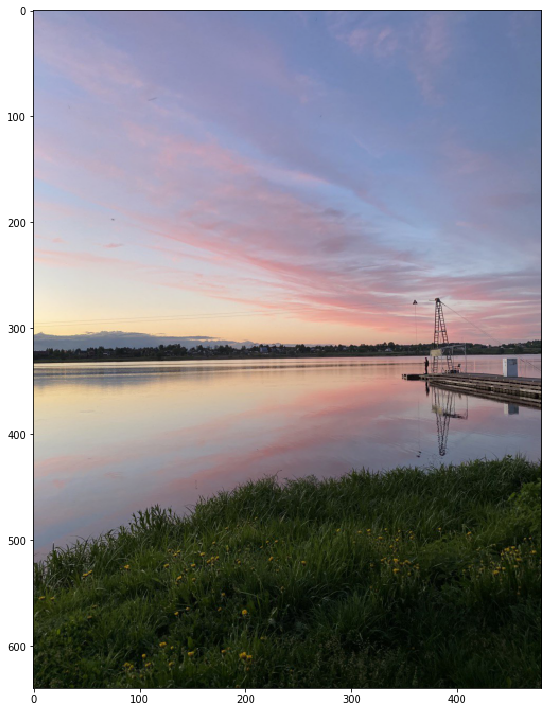

In [26]:
img2 = io.imread('./media/image1.jpg')
img2 = transform.resize(img2, [640, 480]) # Меньше разрешение — быстрее работает
io.imshow(img2)

In [30]:
%%time

# посмотрим как работае цветное само на себе
res = bilateralfilter(img2,
                      img2,
                      50,
                      50/255
                     )

CPU times: user 17min 6s, sys: 3.53 s, total: 17min 9s
Wall time: 17min 10s


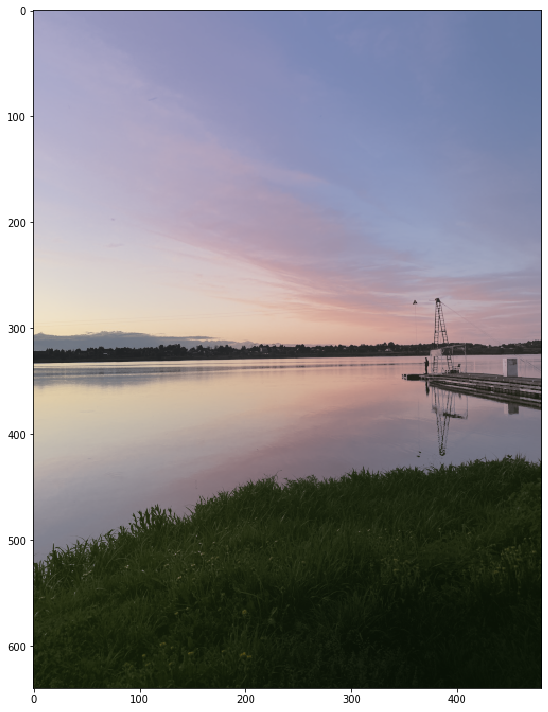

In [31]:
plt.figure
io.imshow(res)